<a href="https://colab.research.google.com/github/jithesh9539/CMPE_255_hotel/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib as mpl
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA,TruncatedSVD
from IPython.display import display, HTML
import datetime as dt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS

**Loading Dataset to Pandas DataFrame**

In [2]:
customer_data=pd.read_csv('/content/data.csv',encoding= 'unicode_escape')

In [3]:
customer_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
customer_data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [6]:
customer_data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

**As 1/4 th of the entries in CustomerID column is null it wouldn't be efficient enough to impute the values and hence would be deleting the records to get a better accuracy while creating a model.** 

In [7]:
customer_data.shape

(541909, 8)

In [8]:
customer_data.dropna(axis = 0, subset = ['CustomerID'], inplace = True)

In [9]:
customer_data.shape

(406829, 8)

In [10]:
customer_data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

**Checking for duplicate records in the dataset**

In [11]:
customer_data.duplicated().sum()

5225

**As there are around 5225 duplicate records we are proceeding to drop the same from dataset**

In [12]:
customer_data.drop_duplicates(inplace=True)

In [13]:
customer_data.shape

(401604, 8)

In [14]:
customer_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


**Identifying the total number of Products,Customers and Transactions in the dataset**

In [15]:
pd.DataFrame([{'products': len(customer_data['StockCode'].value_counts()),    
               'transactions': len(customer_data['InvoiceNo'].value_counts()),
               'customers': len(customer_data['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


**Determining the number of products purchased in every transaction**

In [16]:
det =customer_data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
prod_per_trans= det.rename(columns = {'InvoiceDate':'Number of products'})
prod_per_trans[:20].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346.0,541431,1
1,12346.0,C541433,1
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
5,12347.0,556201,18
6,12347.0,562032,22
7,12347.0,573511,47
8,12347.0,581180,11
12,12348.0,568172,3


**From the above data can observe that the Invoice Containing C as prefix is a cancelled transaction and also there are transactions wherein few of the customers has purchased one or more products**

In [17]:
temp = customer_data[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('Number of Countries in the Dataset: {}'.format(len(countries)))

Number of Countries in the Dataset: 37


In [18]:
data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
#_______________________
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
#______________
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

**The above graph shows the percentage of orders from the top 10 countries, sorted by the number of orders. This shows that more than 90% of orders are coming from United Kingdom and no other country even makes up 3% of the orders in the data.**

**Counting the number of transactions corresponding to canceled orders:**

In [19]:
prod_per_trans['order_canceled'] = prod_per_trans['InvoiceNo'].apply(lambda x:int('C' in x))
display(prod_per_trans[:100])

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346.0,541431,1,0
1,12346.0,C541433,1,1
2,12347.0,537626,31,0
3,12347.0,542237,29,0
4,12347.0,549222,24,0
...,...,...,...,...
95,12381.0,570725,1,0
96,12381.0,574694,16,0
97,12381.0,580638,7,0
98,12381.0,C565050,4,1


**Distribution of Customers by Countries**

In [20]:
customer_country = customer_data[['Country','CustomerID']].drop_duplicates()
customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index(drop=False).sort_values('CustomerID', ascending=False)

,Country,CustomerID
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,15
12,Finland,12
1,Austria,11


In [21]:
a = prod_per_trans['order_canceled'].sum()
b = prod_per_trans.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(a, b, a/b*100))

Number of orders canceled: 3654/22190 (16.47%) 


In [22]:
customer_data.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


As minimum value for the quantity column is -80995 we can observe th

In [23]:
customer_data[(customer_data['Quantity']<0)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom


In [24]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    401604 non-null  object 
 1   StockCode    401604 non-null  object 
 2   Description  401604 non-null  object 
 3   Quantity     401604 non-null  int64  
 4   InvoiceDate  401604 non-null  object 
 5   UnitPrice    401604 non-null  float64
 6   CustomerID   401604 non-null  float64
 7   Country      401604 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.6+ MB


In [25]:
df_check = customer_data[customer_data['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if customer_data[(customer_data['CustomerID'] == col[0]) & (customer_data['Quantity'] == -col[1]) 
                & (customer_data['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


**We see that the initial hypothesis is not fulfilled because of the existence of a 'Discount' entry. I check again the hypothesis but this time discarding the 'Discount' entries:**

In [26]:

df_check = customer_data[(customer_data['Quantity'] < 0) & (customer_data['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  df_check.iterrows():
    if customer_data[(customer_data['CustomerID'] == col[0]) & (customer_data['Quantity'] == -col[1]) 
                & (customer_data['Description'] == col[2])].shape[0] == 0: 
        print(index, df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


**Once more, we find that the initial hypothesis is not verified. Hence, cancellations do not necessarily correspond to orders that would have been made beforehand.**

In [27]:
df_cleaned = customer_data.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = []
doubtfull_entry = []

for index, col in  customer_data.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = customer_data[(customer_data['CustomerID'] == col['CustomerID']) &
                         (customer_data['StockCode']  == col['StockCode']) & 
                         (customer_data['InvoiceDate'] < col['InvoiceDate']) & 
                         (customer_data['Quantity']   > 0)].copy()
    
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    
    # If various counterparts exist in orders, then we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break    

In the above function, we checked for two cases:

if there are canceled orders that exists without counterparts
if there's at least one counterpart with the exact same quantity
The index of the corresponding canceled order are respectively kept in the doubtfull_entry and entry_to_remove lists whose sizes are:

**Drop the entries in doubtfull_entry and entry_to_remove**

In [28]:

df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)




---
**Check if there are still any canceled orders ** ***italicized text***


In [29]:
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("number of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

number of entries to delete: 37


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
27329,C538530,22630,DOLLY GIRL LUNCH BOX,-33,12/13/2010 10:26,1.95,14796.0,United Kingdom,0
32870,C539195,22942,CHRISTMAS LIGHTS 10 SANTAS,-5,12/16/2010 12:05,8.50,12748.0,United Kingdom,0
33085,C539221,22941,CHRISTMAS LIGHTS 10 REINDEER,-12,12/16/2010 12:56,8.50,14911.0,EIRE,0
33086,C539221,22942,CHRISTMAS LIGHTS 10 SANTAS,-10,12/16/2010 12:56,8.50,14911.0,EIRE,0
77599,C542744,22700,BLACK AND WHITE DOG BOWL,-10,1/31/2011 16:32,0.85,16191.0,United Kingdom,0


**# Drop the remaining entries**

In [30]:
df_cleaned.drop(remaining_entries.index, axis = 0, inplace = True)

In [31]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392809 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   InvoiceNo         392809 non-null  object 
 1   StockCode         392809 non-null  object 
 2   Description       392809 non-null  object 
 3   Quantity          392809 non-null  int64  
 4   InvoiceDate       392809 non-null  object 
 5   UnitPrice         392809 non-null  float64
 6   CustomerID        392809 non-null  float64
 7   Country           392809 non-null  object 
 8   QuantityCanceled  392809 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 30.0+ MB


**Stockcode**

In [32]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

**We found some operations ('POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT') that does not characterize the store's customers. So we will just drop these transactions from our database**

In [33]:
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'POST']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'D']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'C2']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'M']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'BANK CHARGES']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'PADS']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'DOT']

In [34]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391183 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   InvoiceNo         391183 non-null  object 
 1   StockCode         391183 non-null  object 
 2   Description       391183 non-null  object 
 3   Quantity          391183 non-null  int64  
 4   InvoiceDate       391183 non-null  object 
 5   UnitPrice         391183 non-null  float64
 6   CustomerID        391183 non-null  float64
 7   Country           391183 non-null  object 
 8   QuantityCanceled  391183 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 29.8+ MB


**Feature Engineering**

In [35]:
def unique_counts(data):
   for i in data.columns:
       count = data[i].nunique()
       print(i, ": ", count)
unique_counts(df_cleaned)

InvoiceNo :  18405
StockCode :  3659
Description :  3871
Quantity :  300
InvoiceDate :  17169
UnitPrice :  356
CustomerID :  4335
Country :  37
QuantityCanceled :  115


**Total Amount**

In [36]:
# Calculate the Total Amount 
df_cleaned['TotalAmount'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])

**With the above line of code, we created a new column for the total amount spent for each transaction.**

Text(0.5, 1.0, 'Revenue per Country')

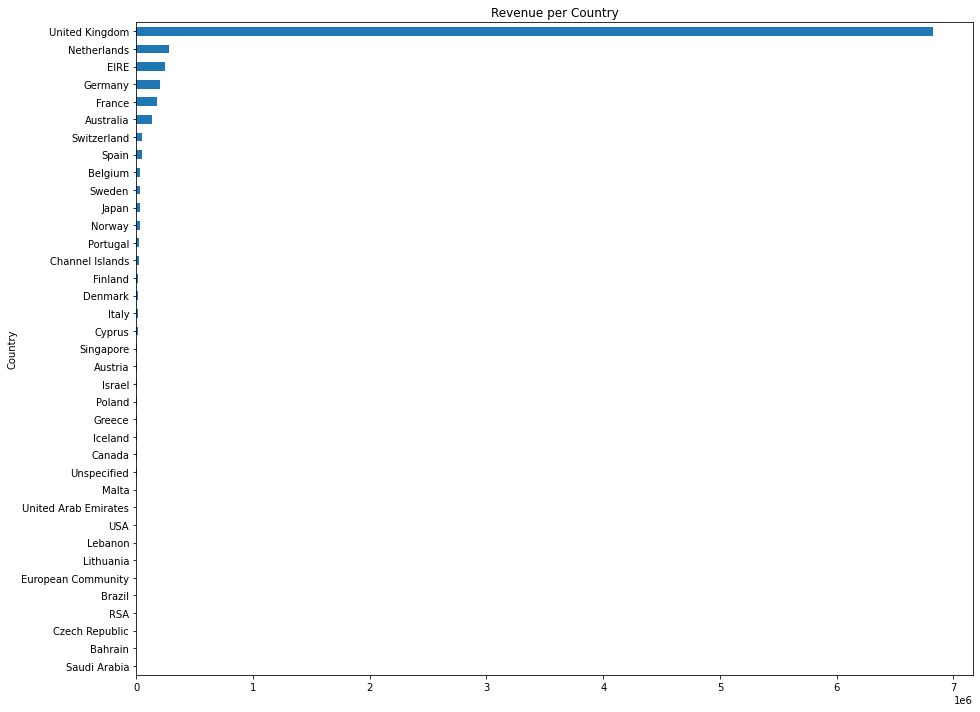

In [37]:
# Total revenue generated per country
revenue_per_country = df_cleaned.groupby(["Country"])["TotalAmount"].sum().sort_values()
revenue_per_country.plot(kind='barh', figsize=(15,12))
plt.title("Revenue per Country")

We can see that the United Kingdom generated the most revenue, with close to 7 million dollars.

In [38]:
# Normalize the labels
le = preprocessing.LabelEncoder()
le.fit(df_cleaned['Country'])

LabelEncoder()

In [39]:
le.classes_

array(['Australia', 'Austria', 'Bahrain', 'Belgium', 'Brazil', 'Canada',
       'Channel Islands', 'Cyprus', 'Czech Republic', 'Denmark', 'EIRE',
       'European Community', 'Finland', 'France', 'Germany', 'Greece',
       'Iceland', 'Israel', 'Italy', 'Japan', 'Lebanon', 'Lithuania',
       'Malta', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'RSA',
       'Saudi Arabia', 'Singapore', 'Spain', 'Sweden', 'Switzerland',
       'USA', 'United Arab Emirates', 'United Kingdom', 'Unspecified'],
      dtype=object)

In [40]:
df_cleaned['Country'] = le.transform(df_cleaned['Country'])

In [41]:
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,35,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,35,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,35,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,35,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,35,0,20.34


### RFM Modeling

Here, we will use RFM analysis, which is a customer segmentation technique that groups customers based on their transaction history. 

RFM stands for Recency, Frequency and Monetary. 

In [42]:
df_cleaned['InvoiceDate'].min()

'1/10/2011 10:32'

In [43]:
df_cleaned['InvoiceDate'].max()

'9/9/2011 9:52'

In [44]:
# Recency = Latest Date - Last Inovice Data
# Set latest date to be one day after the last entry in the databse
Latest_Date = dt.datetime(2011,12,10)
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

In [45]:
#Create RFM Modelling scores for each customer
RFMScores = df_cleaned.groupby('CustomerID').agg({'InvoiceDate': lambda x: (Latest_Date - x.max()).days, 'InvoiceNo': lambda x: len(x), 'TotalAmount': lambda x: x.sum()})

#Convert Invoice Date into type int
RFMScores['InvoiceDate'] = RFMScores['InvoiceDate'].astype(int)

#Rename column names to Recency, Frequency and Monetary
RFMScores.rename(columns={'InvoiceDate': 'Recency', 
                         'InvoiceNo': 'Frequency', 
                         'TotalAmount': 'Monetary'}, inplace=True)

RFMScores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,0.00
1,12347.0,2,182,4310.00
2,12348.0,75,27,1437.24
3,12349.0,18,72,1457.55
4,12350.0,310,16,294.40


In [46]:
quantiles = RFMScores.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
quantiles

{'Frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 98.0},
 'Monetary': {0.25: 299.655, 0.5: 653.24, 0.75: 1611.6999999999998},
 'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 142.0}}

In [47]:
segmented_rfm = RFMScores
           

In [48]:
# Functions to create R, F and M segments
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

Apply a score on each feature of RFM.

In [49]:
segmented_rfm['r_quartile'] = segmented_rfm['Recency'].apply(RScore, args=('Recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['Frequency'].apply(FMScore, args=('Recency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['Monetary'].apply(FMScore, args=('Recency',quantiles,))
segmented_rfm.head()

,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,
12346.0,325,1,0.00,4,4,4
12347.0,2,182,4310.00,1,1,1
12348.0,75,27,1437.24,3,3,1
12349.0,18,72,1457.55,2,2,1
12350.0,310,16,294.40,4,4,1


**Finally we'll set a score for each customer in the database.**

In [50]:
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,
12346.0,325,1,0.00,4,4,4,444
12347.0,2,182,4310.00,1,1,1,111
12348.0,75,27,1437.24,3,3,1,331
12349.0,18,72,1457.55,2,2,1,221
12350.0,310,16,294.40,4,4,1,441


In [51]:
segmented_rfm = segmented_rfm.reset_index()

In [52]:
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFMScore
0,12346.0,325,1,0.00,4,4,4,444
1,12347.0,2,182,4310.00,1,1,1,111
2,12348.0,75,27,1437.24,3,3,1,331
3,12349.0,18,72,1457.55,2,2,1,221
4,12350.0,310,16,294.40,4,4,1,441


In [53]:
df_cleaned = pd.merge(df_cleaned,segmented_rfm, on='CustomerID')

In [54]:
df_cleaned.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'QuantityCanceled', 'TotalAmount',
       'Recency', 'Frequency', 'Monetary', 'r_quartile', 'f_quartile',
       'm_quartile', 'RFMScore'],
      dtype='object')

In [55]:
#We don't need the quartiles anymore, so we'd drop them
df_cleaned = df_cleaned.drop(columns=['r_quartile', 'f_quartile', 'm_quartile'])

Product categories

In the dataframe, products are uniquely identified through the StockCode variable. A shrort description of the products is given in the Description variable. Let's group the products into different categories. **bold text**

In [56]:
import nltk
nltk.download('stopwords')
X = df_cleaned["Description"].unique()

stemmer = nltk.stem.porter.PorterStemmer()
stopword = nltk.corpus.stopwords.words('english')

def stem_and_filter(doc):
    tokens = [stemmer.stem(w) for w in analyzer(doc)]
    return [token for token in tokens if token.isalpha()]

analyzer = TfidfVectorizer().build_analyzer()
CV = TfidfVectorizer(lowercase=True, stop_words="english", analyzer=stem_and_filter, min_df=0.00, max_df=0.3)  # we remove words if it appears in more than 30 % of the corpus (not found stopwords like Box, Christmas and so on)
TF_IDF_matrix = CV.fit_transform(X)
print("TF_IDF_matrix :", TF_IDF_matrix.shape, "of", TF_IDF_matrix.dtype)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
TF_IDF_matrix : (3871, 1694) of float64


In [57]:
svd = TruncatedSVD(n_components = 100)
normalizer = Normalizer(copy=False)

TF_IDF_embedded = svd.fit_transform(TF_IDF_matrix)
TF_IDF_embedded = normalizer.fit_transform(TF_IDF_embedded)
print("TF_IDF_embedded :", TF_IDF_embedded.shape, "of", TF_IDF_embedded.dtype)

TF_IDF_embedded : (3871, 100) of float64


**Model Building**

**In order to define (approximately) the number of clusters that best represents the data, we would use the silhouette score:**

In [58]:
score_tfidf = []

x = list(range(5, 155, 10))

for n_clusters in x:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(TF_IDF_embedded)
    clusters = kmeans.predict(TF_IDF_embedded)
    silhouette_avg = silhouette_score(TF_IDF_embedded, clusters)

    rep = np.histogram(clusters, bins = n_clusters-1)[0]
    score_tfidf.append(silhouette_avg)

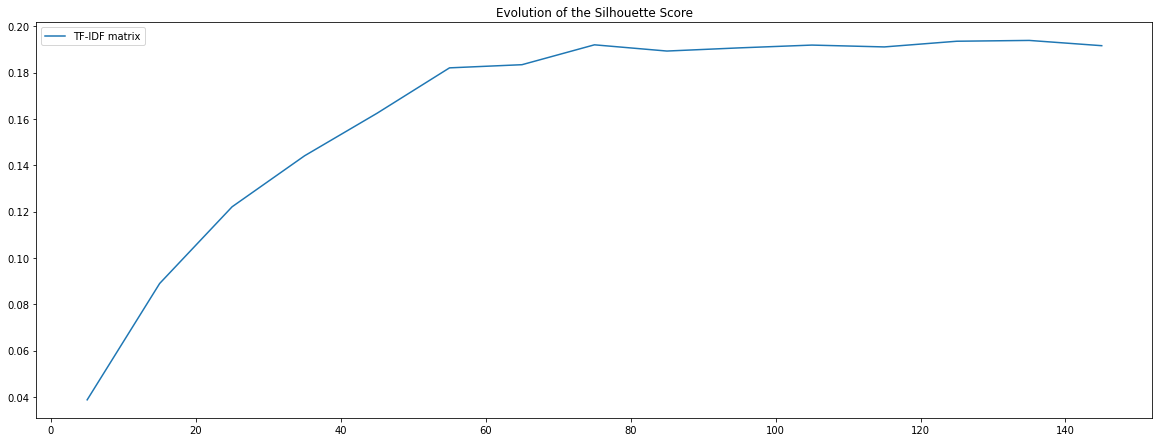

In [59]:
plt.figure(figsize=(20,16))

plt.subplot(2, 1, 1)
plt.plot(x, score_tfidf, label="TF-IDF matrix")
plt.title("Evolution of the Silhouette Score")
plt.legend()

The highest value for the silhouette score is when there are 150 clusters. So we'll choose this value

Text(0.5, 1.0, 'ACP with 135 clusters')

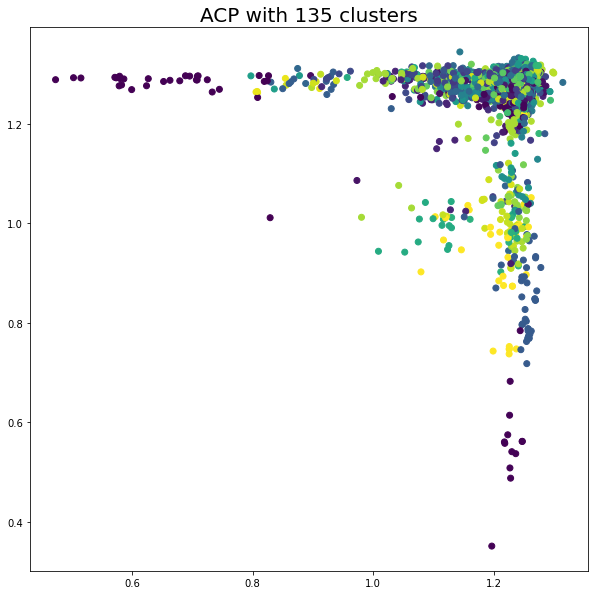

In [60]:
n_clusters = 150

kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30, random_state=0)
proj = kmeans.fit_transform(TF_IDF_embedded)
clusters = kmeans.predict(TF_IDF_embedded)
plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("ACP with 135 clusters", fontsize="20")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



Text(0.5, 1.0, 'Visualization of the clustering with TSNE')

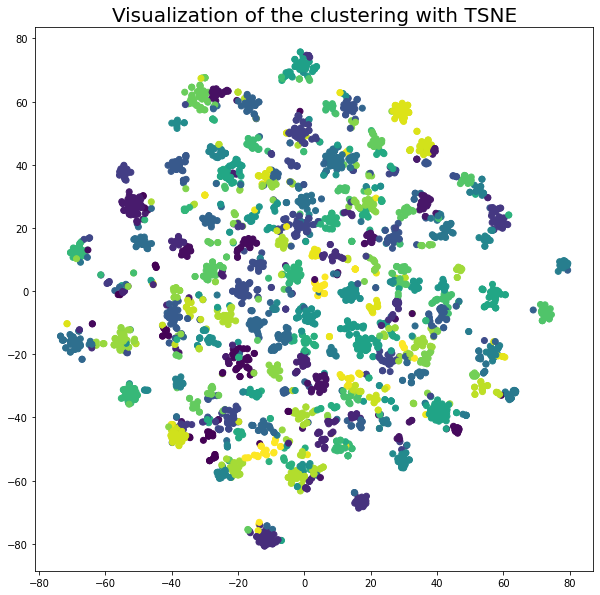

In [61]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(TF_IDF_embedded)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualization of the clustering with TSNE", fontsize="20")


Customer categories

In [62]:
#Grouped by invoices

dict_article_to_cluster = {article : cluster for article, cluster in zip(X, clusters)}
cluster = df_cleaned['Description'].apply(lambda x : dict_article_to_cluster[x])
df2 = pd.get_dummies(cluster, prefix="Cluster").mul(df_cleaned["TotalAmount"], 0)
df2 = pd.concat([df_cleaned['InvoiceNo'], df2], axis=1)
df2_grouped = df2.groupby('InvoiceNo').sum()

In [63]:
custom_aggregation = {}
custom_aggregation["TotalAmount"] = lambda x:x.iloc[0]
custom_aggregation["Recency"] = lambda x:x.iloc[0]
custom_aggregation["Frequency"] = lambda x:x.iloc[0]
custom_aggregation["Monetary"] = lambda x:x.iloc[0]
custom_aggregation["CustomerID"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"
custom_aggregation["Country"] = lambda x:x.iloc[0]

df_grouped = df_cleaned.groupby("InvoiceNo").agg(custom_aggregation)

In [64]:
#Grouped by Customers

df2_grouped_final = pd.concat([df_grouped['CustomerID'], df2_grouped], axis=1).set_index("CustomerID").groupby("CustomerID").sum()
df2_grouped_final = df2_grouped_final.div(df2_grouped_final.sum(axis=1), axis=0)
df2_grouped_final = df2_grouped_final.fillna(0)

In [65]:
custom_aggregation = {}
custom_aggregation["TotalAmount"] = ['min','max','mean']
custom_aggregation["Recency"] = lambda x:x.iloc[0]
custom_aggregation["Frequency"] = lambda x:x.iloc[0]
custom_aggregation["Monetary"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"
custom_aggregation["Country"] = lambda x:x.iloc[0]

df_grouped_final = df_grouped.groupby("CustomerID").agg(custom_aggregation)

In [66]:
df_grouped_final.head()

TotalAmount                    ... Monetary Quantity  Country
                   min    max       mean  ... <lambda>      sum <lambda>
CustomerID                                ...                           
12346.0            0.0    0.0   0.000000  ...     0.00    74215       35
12347.0           13.2   45.0  23.308571  ...  4310.00     2458       16
12348.0           39.6  150.0  82.840000  ...  1437.24     2332       12
12349.0           15.0   15.0  15.000000  ...  1457.55      630       18
12350.0           25.2   25.2  25.200000  ...   294.40      196       24

[5 rows x 8 columns]

In [67]:
df_grouped_final.columns = ["min", "max", "mean", "Recency", "Frequency", "Monetary", "Quantity", "Country"]
df_grouped_final.head()

,min,max,mean,Recency,Frequency,Monetary,Quantity,Country
CustomerID,,,,,,,,
12346.0,0.0,0.0,0.000000,325,1,0.00,74215,35
12347.0,13.2,45.0,23.308571,2,182,4310.00,2458,16
12348.0,39.6,150.0,82.840000,75,27,1437.24,2332,12
12349.0,15.0,15.0,15.000000,18,72,1457.55,630,18
12350.0,25.2,25.2,25.200000,310,16,294.40,196,24


In [68]:
df2_grouped_final.head()

,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10,Cluster_11,Cluster_12,Cluster_13,Cluster_14,Cluster_15,Cluster_16,Cluster_17,Cluster_18,Cluster_19,Cluster_20,Cluster_21,Cluster_22,Cluster_23,Cluster_24,Cluster_25,Cluster_26,Cluster_27,Cluster_28,Cluster_29,Cluster_30,Cluster_31,Cluster_32,Cluster_33,Cluster_34,Cluster_35,Cluster_36,Cluster_37,Cluster_38,Cluster_39,...,Cluster_110,Cluster_111,Cluster_112,Cluster_113,Cluster_114,Cluster_115,Cluster_116,Cluster_117,Cluster_118,Cluster_119,Cluster_120,Cluster_121,Cluster_122,Cluster_123,Cluster_124,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134,Cluster_135,Cluster_136,Cluster_137,Cluster_138,Cluster_139,Cluster_140,Cluster_141,Cluster_142,Cluster_143,Cluster_144,Cluster_145,Cluster_146,Cluster_147,Cluster_148,Cluster_149
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12346.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
12347.0,0.0,0.003081,0.0,0.0,0.000000,0.003884,0.0,0.002923,0.000000,0.003480,0.0,0.0,0.0,0.007889,0.000000,0.0,0.0,0.0,0.0,0.008701,0.0,0.002715,0.0,0.0,0.014200,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.004037,0.000000,0.0,0.0,0.000000,0.006032,0.0,0.000000,0.042877,...,0.000000,0.009234,0.015278,0.002367,0.0,0.089722,0.0,0.0,0.0,0.0,0.0,0.006961,0.023596,0.0,0.0,0.0,0.0,0.00348,0.004594,0.0,0.000000,0.063258,0.008770,0.0,0.017374,0.018376,0.0,0.0,0.020589,0.000000,0.00522,0.003898,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
12348.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.121065,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.204559,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.188862,0.00000,0.027553,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
12349.0,0.0,0.000000,0.0,0.0,0.008748,0.049604,0.0,0.027409,0.055408,0.025481,0.0,0.0,0.0,0.000000,0.013653,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.018552,0.0,0.0,0.000000,0.010291,0.011526,0.0,0.011938,0.004556,0.0,0.0,0.000000,0.000000,0.0,0.055916,0.027196,...,0.005351,0.040465,0.038112,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.012144,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.013584,0.008576,0.023876,0.0,0.024939,0.013584,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.01132,0.010188,0.0,0.0,0.0,0.0
12350.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.067255,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.136549,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.063519,0.060122,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.067255,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0


**Clustering Customers**

In [69]:
# Standardization

X1 = df_grouped_final.values
X2 = df2_grouped_final.values

scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
X_final_std_scale = np.concatenate((X1, X2), axis=1)

**K-Means Clustering**

In [70]:
x = list(range(2, 12))
y_std = []
for n_clusters in x:
    print("n_clusters =", n_clusters)
    
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(X_final_std_scale)
    clusters = kmeans.predict(X_final_std_scale)
    silhouette_avg = silhouette_score(X_final_std_scale, clusters)
    y_std.append(silhouette_avg)
    print("The average silhouette_score is :", silhouette_avg, "with Std Scaling")

n_clusters = 2
The average silhouette_score is : 0.9054113347751834 with Std Scaling
n_clusters = 3
The average silhouette_score is : 0.9023373841844111 with Std Scaling
n_clusters = 4
The average silhouette_score is : 0.5819477670369615 with Std Scaling
n_clusters = 5
The average silhouette_score is : 0.4462804451321869 with Std Scaling
n_clusters = 6
The average silhouette_score is : 0.4655231542792395 with Std Scaling
n_clusters = 7
The average silhouette_score is : 0.4700196927386975 with Std Scaling
n_clusters = 8
The average silhouette_score is : 0.469605315683973 with Std Scaling
n_clusters = 9
The average silhouette_score is : 0.4464824459924881 with Std Scaling
n_clusters = 10
The average silhouette_score is : 0.4633180933071949 with Std Scaling
n_clusters = 11
The average silhouette_score is : 0.4634092323604206 with Std Scaling


In [71]:
kmeans = KMeans(init='k-means++', n_clusters = 8, n_init=30, random_state=0)  # random state so as to provide cluster numbers during analysis
kmeans.fit(X_final_std_scale)
clusters = kmeans.predict(X_final_std_scale)

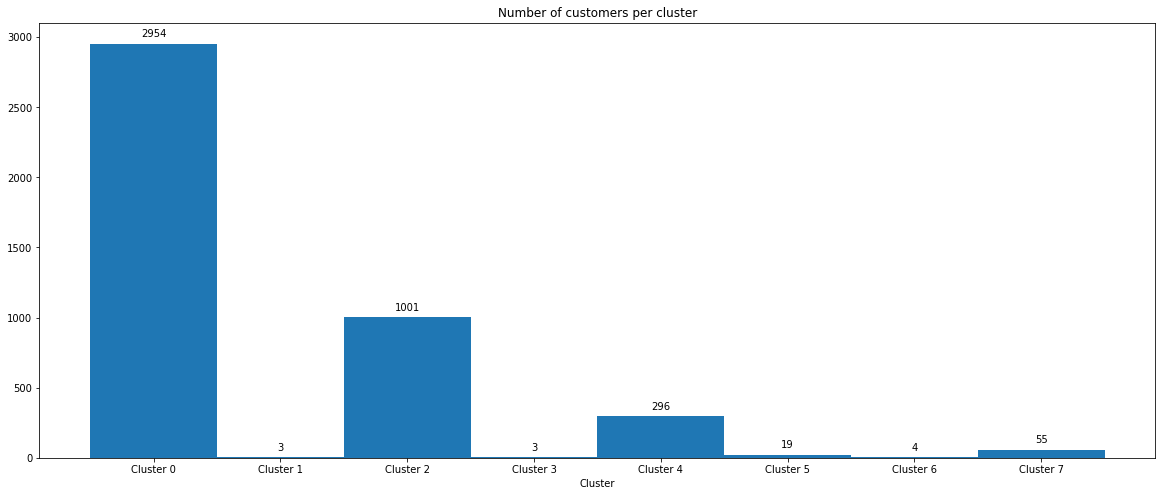

In [72]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(clusters, bins=8)
plt.xlabel("Cluster")
plt.title("Number of customers per cluster")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Cluster {}".format(x) for x in range(8)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [73]:
df_grouped_final["cluster"] = clusters

In [74]:
final_dataset = pd.concat([df_grouped_final, df2_grouped_final], axis = 1)
final_dataset.head()

,min,max,mean,Recency,Frequency,Monetary,Quantity,Country,cluster,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10,Cluster_11,Cluster_12,Cluster_13,Cluster_14,Cluster_15,Cluster_16,Cluster_17,Cluster_18,Cluster_19,Cluster_20,Cluster_21,Cluster_22,Cluster_23,Cluster_24,Cluster_25,Cluster_26,Cluster_27,Cluster_28,Cluster_29,Cluster_30,...,Cluster_110,Cluster_111,Cluster_112,Cluster_113,Cluster_114,Cluster_115,Cluster_116,Cluster_117,Cluster_118,Cluster_119,Cluster_120,Cluster_121,Cluster_122,Cluster_123,Cluster_124,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134,Cluster_135,Cluster_136,Cluster_137,Cluster_138,Cluster_139,Cluster_140,Cluster_141,Cluster_142,Cluster_143,Cluster_144,Cluster_145,Cluster_146,Cluster_147,Cluster_148,Cluster_149
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12346.0,0.0,0.0,0.000000,325,1,0.00,74215,35,5,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
12347.0,13.2,45.0,23.308571,2,182,4310.00,2458,16,4,0.0,0.003081,0.0,0.0,0.000000,0.003884,0.0,0.002923,0.000000,0.003480,0.0,0.0,0.0,0.007889,0.000000,0.0,0.0,0.0,0.0,0.008701,0.0,0.002715,0.0,0.0,0.014200,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.009234,0.015278,0.002367,0.0,0.089722,0.0,0.0,0.0,0.0,0.0,0.006961,0.023596,0.0,0.0,0.0,0.0,0.00348,0.004594,0.0,0.000000,0.063258,0.008770,0.0,0.017374,0.018376,0.0,0.0,0.020589,0.000000,0.00522,0.003898,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
12348.0,39.6,150.0,82.840000,75,27,1437.24,2332,12,4,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.188862,0.00000,0.027553,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
12349.0,15.0,15.0,15.000000,18,72,1457.55,630,18,4,0.0,0.000000,0.0,0.0,0.008748,0.049604,0.0,0.027409,0.055408,0.025481,0.0,0.0,0.0,0.000000,0.013653,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.018552,0.0,0.0,0.000000,0.010291,0.011526,0.0,...,0.005351,0.040465,0.038112,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.012144,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.013584,0.008576,0.023876,0.0,0.024939,0.013584,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.01132,0.010188,0.0,0.0,0.0,0.0
12350.0,25.2,25.2,25.200000,310,16,294.40,196,24,2,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.067255,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.136549,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.067255,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0


In [75]:
final_dataset_V2 = final_dataset.reset_index()
final_dataset_V2.to_csv("final_dataset_V2.csv",index=False)

In [76]:
import pickle
pickle.dump(kmeans, open('model.pkl','wb'))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



Text(0.5, 1.0, 'Visualization of the clustering with TSNE')

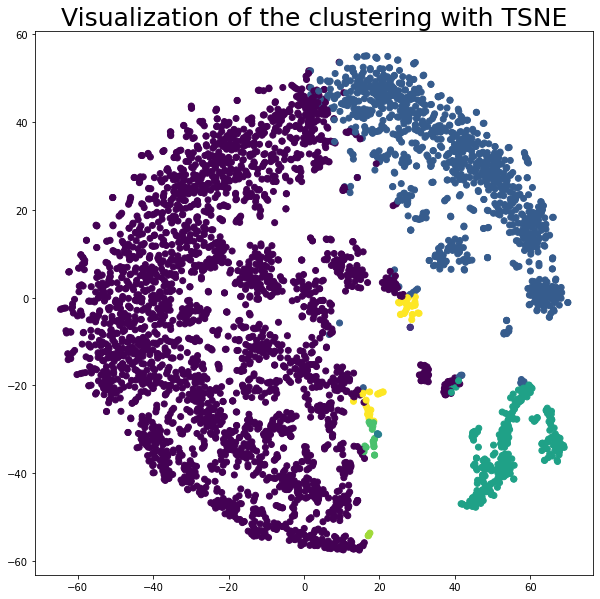

In [77]:
## Interpreting the clusters
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(X_final_std_scale)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualization of the clustering with TSNE", fontsize="25")